## 進階機器學習 HW5-1

* 學號: B103040047
* 姓名: 周安

In [79]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchinfo import summary
import pandas as pd

In [80]:
import random

import torch
import numpy as np

# for reproduce rsult
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    generator = torch.Generator().manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    return generator
generator = same_seeds(122)

# Check available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Train on {device}.")

Train on cuda.


### Load the MNIST & FashionMNIST dataseet.

In [249]:
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset
# preprocess
BATCH_SIZE = 64
compose = [
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),  # Update mean/std for 1 channel, normalize value into [-1, 1]
]
transform = transforms.Compose(compose)

# MNIST Training Data（normal data）
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# MNIST Test Data
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Fashion-MNIST Test Data
# 10 classes.
fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# to test together
combined_test = ConcatDataset([mnist_test, fashion_test])

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)
fashion_test_loader = DataLoader(fashion_test, batch_size=BATCH_SIZE, shuffle=False)
combined_test_loader = DataLoader(combined_test, batch_size=BATCH_SIZE, shuffle=False)

print("MNIST Train:", len(mnist_train))
print("MNIST Test:", len(mnist_test))
print("Fashion-MNIST Test:", len(fashion_test))
print("Combined Test:", len(combined_test))

MNIST Train: 60000
MNIST Test: 10000
Fashion-MNIST Test: 10000
Combined Test: 20000


In [82]:
fashion_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def show_10_images(dataset, labels=None):
    plt.figure(figsize=(15, 5))
    for i, img_idx in enumerate(range(0, 10)):
        image, label = dataset[img_idx]

        # image subplot
        ax_img = plt.subplot(2, 5, i + 1)
        ax_img.imshow(image.squeeze(), cmap='gray')
        ax_img.axis("off")
        if labels == None:
            ax_img.set_title(f"GT: {label}", fontsize=10)
        else:
            ax_img.set_title(f"GT: {labels[label]}", fontsize=10)

    plt.tight_layout()
    plt.show()

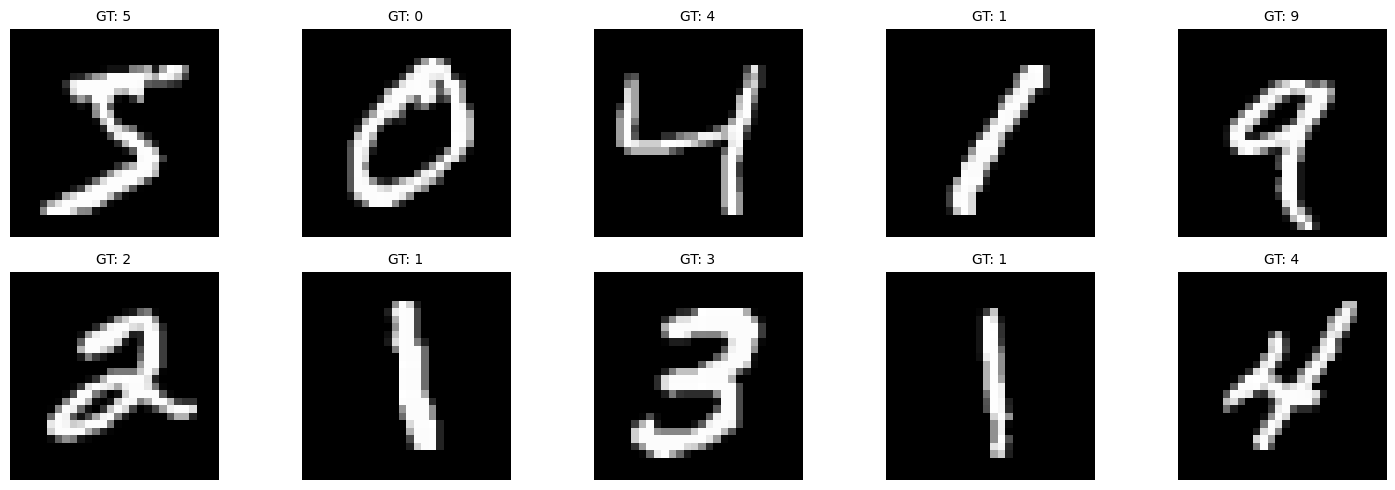

In [83]:
# See train dataset.
show_10_images(mnist_train)

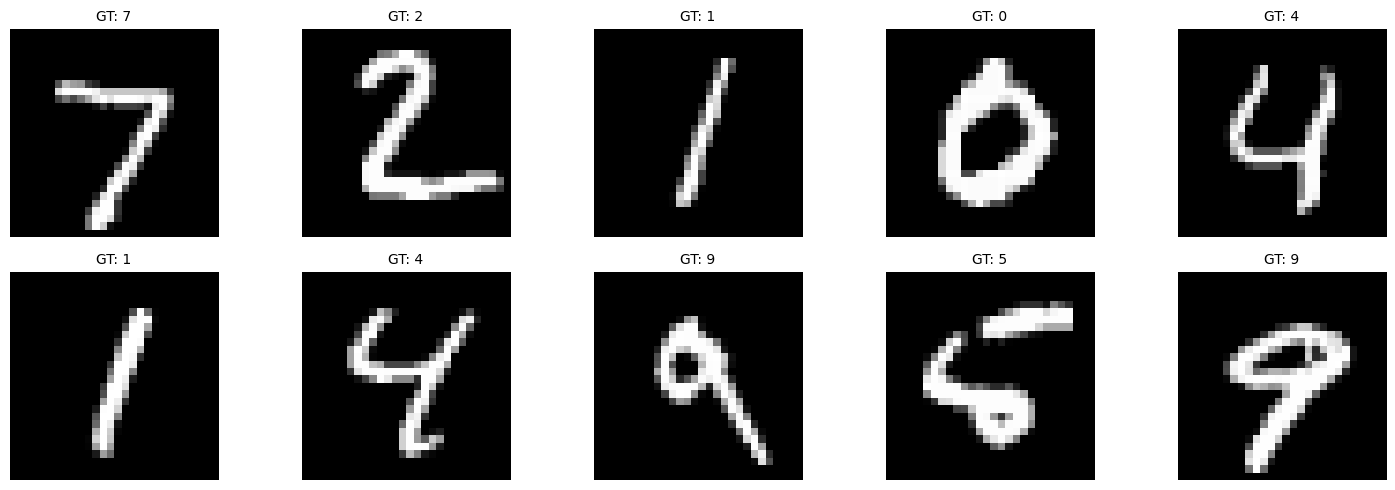

In [84]:
# See test dataset.
show_10_images(mnist_test)

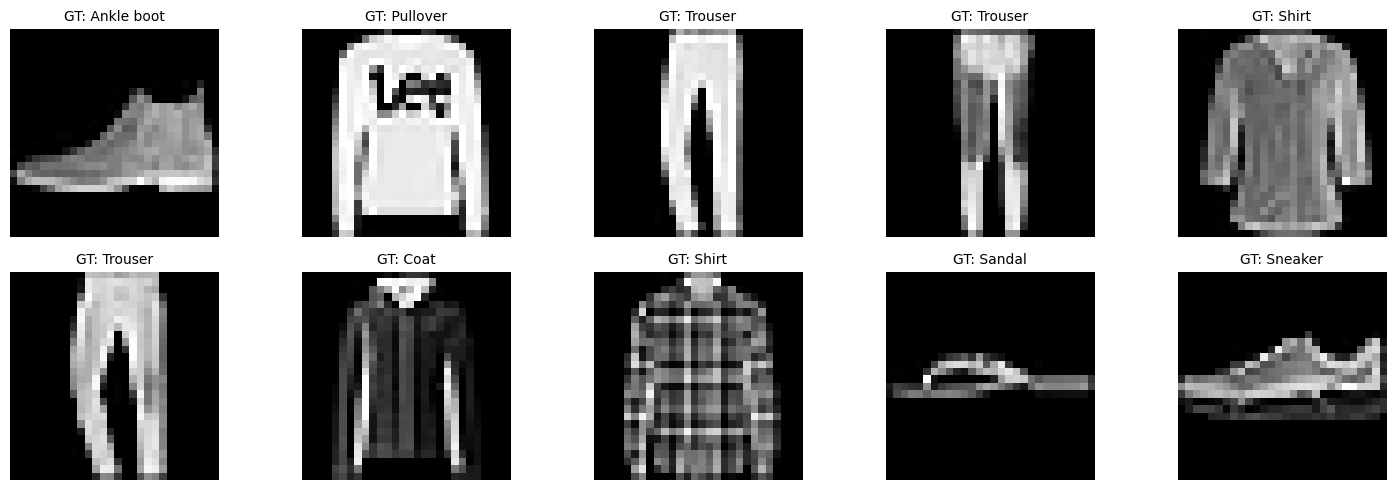

In [85]:
# See test dataset.
show_10_images(fashion_test, labels = fashion_classes)

## 1. Train an image classifier using the normal data (MNIST training set). Use this classifier to detect anomalies by identifying Fashion-MNIST images in the test dataset.

### 1.1 RNN model.

In [86]:
# Hyper Parameters
LR = 0.001
NUM_EPOCHS = 10
IMAGE_SIZE = 28
SEQ_LEN = 2

In [87]:
# define RNN model
class RNN_model_MNIST(nn.Module):
    def __init__(self):
        super(RNN_model_MNIST, self).__init__()
        self.rnn_layers = nn.RNN(IMAGE_SIZE*IMAGE_SIZE//SEQ_LEN, 128, num_layers = 1, batch_first = True) # (input size, output size)
        
        self.classifier_layers = nn.Sequential(
                # Flatten layers
                nn.Linear(128, 10),
            )
        
        
    
    def forward(self, x):
        x = x.squeeze(1) # (batch_size, 1, 28, 28) → (batch_size, 28, 28)
        x = x.reshape(x.shape[0], SEQ_LEN, -1)
        output, _ = self.rnn_layers(x) # output shape is (N, seq_len, Hout)
        # output's shape is (Batch_size, seq_len, Hout)
        
        # Try use all time steps data
        # x = output.reshape(x.size(0), -1)
        
        # Try just see the final time step output
        x = output[:, -1, :]  # get last time step (batch_size, H_out)
        x = self.classifier_layers(x)
        return x

In [97]:
model_rnn = RNN_model_MNIST().to(device)

# pth_path = 'MNIST_model_RNN.pth'
# state_dict = torch.load(pth_path)
# model.load_state_dict(state_dict)
# print(f"Load pth from {pth_path}")

# set loss function
criterion = nn.CrossEntropyLoss()
# set optimizer
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=LR, betas=(0.9, 0.999))
# let the LR decay after 10 epochs
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
# Print the model summary
# summary(model, (1, IMAGE_SIZE, IMAGE_SIZE)) # Input size: (Batch_size, height, width), torchinfo.summary need batch size
summary(model_rnn, (1, SEQ_LEN, IMAGE_SIZE*IMAGE_SIZE//SEQ_LEN)) # Input size: (Batch_size, height, width), torchinfo.summary need batch size

Layer (type:depth-idx)                   Output Shape              Param #
RNN_model_MNIST                          [1, 10]                   --
├─RNN: 1-1                               [1, 2, 128]               66,816
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 10]                   1,290
Total params: 68,106
Trainable params: 68,106
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.27
Estimated Total Size (MB): 0.28

In [103]:
from tqdm import tqdm
# train and val func for one epoch
def train_epoch(train_dataloader, model):
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for x, y in tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)
        # clear gradients
        optimizer.zero_grad()
        # predicting
        y_pred = model(x)
        # see loss
        loss = criterion(y_pred, y)
        loss.backward()
        
        # update the parameters
        optimizer.step()

        train_loss += loss.item() * BATCH_SIZE
        probs = torch.nn.functional.softmax(y_pred, dim=1)
        train_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return train_acc / len(train_dataloader.dataset), train_loss / len(train_dataloader.dataset)

def val_epoch(val_dataloader, model):
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(val_dataloader):
            x, y = x.to(device), y.to(device)
            # predicting
            y_pred = model(x)
            # see loss
            loss = criterion(y_pred, y)

            val_loss += loss.item() * BATCH_SIZE
            probs = torch.nn.functional.softmax(y_pred, dim=1)
            val_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return val_acc / len(val_dataloader.dataset), val_loss / len(val_dataloader.dataset)

def test(test_dataloader, model, type=None):
    pred_labels = []
    total_probs = []
    true_labels = [] # for testing train dataset
    model.eval()
    with torch.no_grad():
        if type == "test":
            for x, _ in tqdm(test_dataloader):
                x = x.to(device)
                # predicting
                y_pred = model(x)
                probs = torch.nn.functional.softmax(y_pred, dim=1)
                total_probs.append(probs)
                pred_labels.extend(torch.argmax(probs, dim=1).cpu().tolist())
            return torch.cat(total_probs, dim=0), pred_labels

        else:
            for x, y in tqdm(test_dataloader):
                x = x.to(device)
                # predicting
                y_pred = model(x)
                probs = torch.nn.functional.softmax(y_pred, dim=1)
                total_probs.append(probs)
                pred_labels.extend(torch.argmax(probs, dim=1).cpu().tolist())
                true_labels.extend(y.cpu().tolist())
            return torch.cat(total_probs, dim=0), pred_labels, true_labels

def plt_loss_accuracy_fig(Total_training_loss, Total_validation_loss, Total_training_accuracy, Total_validation_accuracy):
    # visualization the loss and accuracy
    plt.figure()
    plt.plot(range(len(Total_training_loss)), Total_training_loss, 'b-', label='Training_loss')
    plt.plot(range(len(Total_validation_loss)), Total_validation_loss, 'g-', label='validation_loss')
    plt.title('Training & Validation loss')
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(len(Total_training_accuracy)), Total_training_accuracy, 'r-', label='Training_accuracy')
    plt.plot(range(len(Total_validation_accuracy)), Total_validation_accuracy, 'y-', label='Validation_accuracy')
    plt.title('Training & Validation accuracy')
    plt.xlabel('No. of epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Test dataloader below only contain mnist test data.

In [100]:
# Start training and testing
max_accuracy = 0
# For ploting the trend image
total_train_acc = []
total_val_acc = []
total_train_loss = []
total_val_loss = []
for i in range(NUM_EPOCHS):
    train_acc, train_loss = train_epoch(train_loader, model_rnn)
    val_acc, val_loss = val_epoch(mnist_test_loader, model_rnn)
    # record the training data
    total_train_acc.append(train_acc)
    total_val_acc.append(val_acc)

    total_train_loss.append(train_loss)
    total_val_loss.append(val_loss)

    print("Epoch[{:>2d}/{:>2d}] : train_acc = {:.4f}, train_loss = {:.4f}, val_acc = {:.4f}, val_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_acc, train_loss, val_acc, val_loss))
    # update model pth when larger val_acc happens
    if(val_acc > max_accuracy):
        max_accuracy = val_acc
        save_parameters = True
        if save_parameters:
            path = 'MNIST_model_RNN.pth'
            torch.save(model_rnn.state_dict(), path)
            print("\t\33[33m====Save model parameters in {:s} when val_acc is {:.4f}====\33[0m".format(path, val_acc))

# save the final epoch's model
path = 'MNIST_model_RNN_final_epoch.pth'
torch.save(model_rnn.state_dict(), path)
print("\t\33[33m====Save FINAL model parameters in {:s}====\33[0m".format(path))

100%|██████████| 157/157 [00:01<00:00, 140.80it/s]


Epoch[ 1/10] : train_acc = 0.9044, train_loss = 0.3351, val_acc = 0.9493, val_loss = 0.1755
	====Save model parameters in MNIST_model_RNN.pth when val_acc is 0.9493====


100%|██████████| 157/157 [00:01<00:00, 155.45it/s]


Epoch[ 2/10] : train_acc = 0.9556, train_loss = 0.1484, val_acc = 0.9616, val_loss = 0.1287
	====Save model parameters in MNIST_model_RNN.pth when val_acc is 0.9616====


100%|██████████| 157/157 [00:01<00:00, 145.45it/s]


Epoch[ 3/10] : train_acc = 0.9675, train_loss = 0.1091, val_acc = 0.9693, val_loss = 0.1035
	====Save model parameters in MNIST_model_RNN.pth when val_acc is 0.9693====


100%|██████████| 157/157 [00:01<00:00, 144.13it/s]


Epoch[ 4/10] : train_acc = 0.9736, train_loss = 0.0879, val_acc = 0.9718, val_loss = 0.0951
	====Save model parameters in MNIST_model_RNN.pth when val_acc is 0.9718====


100%|██████████| 157/157 [00:01<00:00, 146.85it/s]


Epoch[ 5/10] : train_acc = 0.9773, train_loss = 0.0753, val_acc = 0.9739, val_loss = 0.0905
	====Save model parameters in MNIST_model_RNN.pth when val_acc is 0.9739====


100%|██████████| 157/157 [00:01<00:00, 148.89it/s]


Epoch[ 6/10] : train_acc = 0.9812, train_loss = 0.0636, val_acc = 0.9733, val_loss = 0.0879


100%|██████████| 157/157 [00:01<00:00, 142.26it/s]


Epoch[ 7/10] : train_acc = 0.9828, train_loss = 0.0576, val_acc = 0.9715, val_loss = 0.0890


100%|██████████| 157/157 [00:01<00:00, 114.34it/s]


Epoch[ 8/10] : train_acc = 0.9839, train_loss = 0.0514, val_acc = 0.9689, val_loss = 0.1034


100%|██████████| 157/157 [00:01<00:00, 104.35it/s]


Epoch[ 9/10] : train_acc = 0.9860, train_loss = 0.0457, val_acc = 0.9739, val_loss = 0.0863


100%|██████████| 157/157 [00:01<00:00, 103.83it/s]

Epoch[10/10] : train_acc = 0.9870, train_loss = 0.0420, val_acc = 0.9757, val_loss = 0.0721
	====Save model parameters in MNIST_model_RNN.pth when val_acc is 0.9757====
	====Save FINAL model parameters in MNIST_model_RNN_final_epoch.pth====


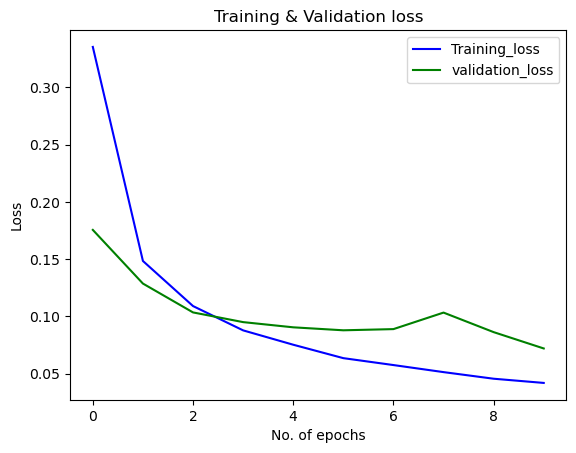

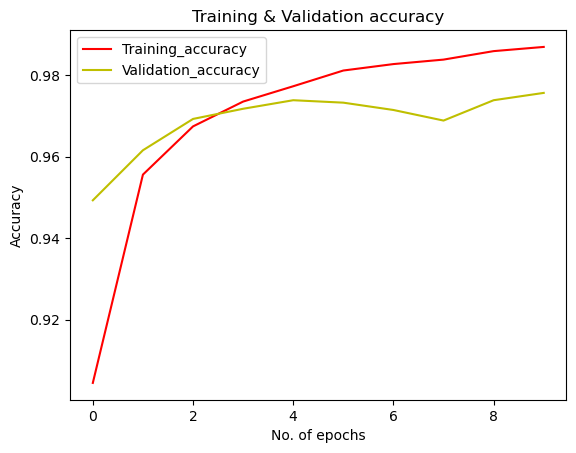

In [101]:
plt_loss_accuracy_fig(total_train_loss, total_val_loss, total_train_acc, total_val_acc)

Test on fashion mnist dataset, so it will get bad acc.

In [104]:
# Start training and testing
max_accuracy = 0
# For ploting the trend image
total_val_acc = []
total_val_loss = []
for i in range(1):
    val_acc, val_loss = val_epoch(fashion_test_loader, model_rnn)
    # record the training data
    total_val_acc.append(val_acc)

    total_val_loss.append(val_loss)

    print("val_acc = {:.4f}, val_loss = {:.4f}".format(val_acc, val_loss))

100%|██████████| 157/157 [00:01<00:00, 140.49it/s]

val_acc = 0.1151, val_loss = 8.0786


In [105]:
# Start training and testing
max_accuracy = 0
# For ploting the trend image
total_val_acc = []
total_val_loss = []
for i in range(1):
    val_acc, val_loss = val_epoch(mnist_test_loader, model_rnn)
    # record the training data
    total_val_acc.append(val_acc)

    total_val_loss.append(val_loss)

    print("val_acc = {:.4f}, val_loss = {:.4f}".format(val_acc, val_loss))

100%|██████████| 157/157 [00:01<00:00, 144.33it/s]

val_acc = 0.9757, val_loss = 0.0721


### 1.2.1 Reload the model, and Use this rnn classifier to detect anomalies by identifying Fashion-MNIST images in the test dataset.
By the below exepriments, I find that many max probs predicted from Fashion MNIST are lower than data in MNIST.
So, I set a threshold to detect the fashion MNIST data.

In [106]:
model_rnn = RNN_model_MNIST().to(device)
pth_path = 'MNIST_model_RNN.pth'
state_dict = torch.load(pth_path)
model_rnn.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")

Load pth from MNIST_model_RNN.pth


#### 1.2.2 Set the threshold
By getting all the max probs, and see the roc curve to find the best threshold.

100%|██████████| 157/157 [00:00<00:00, 170.89it/s]


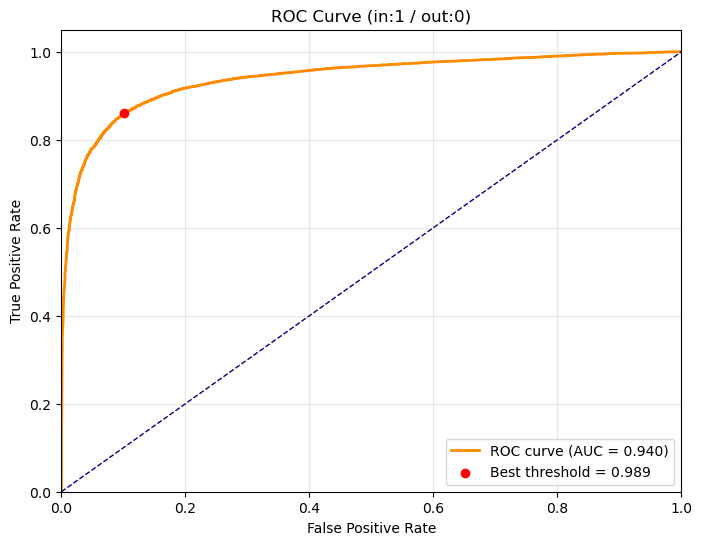

Best threshold on max prob: 0.989304


In [107]:
from sklearn.metrics import roc_curve, auc
# Record all the max probs
mnist_max_probs = []
fashion_max_probs = [] 
# test on fashion mnist first
total_probs, pred_labels = test(fashion_test_loader, model_rnn, type="test")
for i in total_probs.cpu().numpy():
    fashion_max_probs.append(np.max(i))
# test on mnist
total_probs, pred_labels, true_labels = test(mnist_test_loader, model_rnn)
for i in total_probs.cpu().numpy():
    mnist_max_probs.append(np.max(i))

y_true = np.array([1]*len(mnist_max_probs) + [0]*len(fashion_max_probs))
y_scores = np.array(list(mnist_max_probs) + list(fashion_max_probs))

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

youden_j = tpr - fpr
BEST_TH_1 = thresholds[np.argmax(youden_j)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

# mark best threshold
plt.scatter(fpr[np.argmax(youden_j)], tpr[np.argmax(youden_j)],
            color='red', label=f'Best threshold = {BEST_TH_1:.3f}', zorder=5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (in:1 / out:0)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f'Best threshold on max prob: {BEST_TH_1:.6f}')

#### 1.3 Show the result  of detecting anomalies in the test dataset.

In [108]:
mnsit_acc = 0.0
fashion_acc = 0.0
total_test_acc = 0.0
total_probs, pred_labels= test(combined_test_loader, model_rnn, type="test")
for i in total_probs[:len(mnist_test)].cpu().numpy():
    if np.max(i) >= BEST_TH_1:
        mnsit_acc += 1
        total_test_acc += 1
print(f"Achieved {mnsit_acc/len(mnist_test)*100:.4f}% accuracy in detecting in- and out-of-distribution samples on the mnist dataset.")
for i in total_probs[len(mnist_test):].cpu().numpy():
    if np.max(i) < BEST_TH_1:
        fashion_acc += 1
        total_test_acc += 1
print(f"Achieved {fashion_acc/len(fashion_test)*100:.4f}% accuracy in detecting in- and out-of-distribution samples on the fashion dataset.")

print(f"Achieved {total_test_acc/len(combined_test)*100:.4f}% accuracy in detecting in- and out-of-distribution samples on the combined test dataset (MNIST and Fashion-MNIST).")

100%|██████████| 313/313 [00:02<00:00, 150.41it/s]


Achieved 85.9600% accuracy in detecting in- and out-of-distribution samples on the mnist dataset.
Achieved 89.9700% accuracy in detecting in- and out-of-distribution samples on the fashion dataset.
Achieved 87.9650% accuracy in detecting in- and out-of-distribution samples on the combined test dataset (MNIST and Fashion-MNIST).


## 2. Train a standard **autoencoder** on the normal data. Use its reconstruction error as a basis for detecting anomalies in the test dataset.
### 2.1. autoencoder

In [109]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 1, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [110]:
# Hyper Parameters
LR = 0.001
NUM_EPOCHS = 10
IMAGE_SIZE = 28

model_cnn_AE = conv_autoencoder().to(device)

# set loss function
criterion = nn.MSELoss()
# set optimizer
optimizer = torch.optim.Adam(model_cnn_AE.parameters(), lr=LR, betas=(0.9, 0.999))
# Print the model summary
summary(model_cnn_AE, (1, IMAGE_SIZE, IMAGE_SIZE)) # Input size: (Batch_size, height, width), torchinfo.summary need batch size

Layer (type:depth-idx)                   Output Shape              Param #
conv_autoencoder                         [1, 28, 28]               --
├─Sequential: 1-1                        [24, 7, 7]                --
│    └─Conv2d: 2-1                       [12, 14, 14]              204
│    └─ReLU: 2-2                         [12, 14, 14]              --
│    └─Conv2d: 2-3                       [24, 7, 7]                4,632
│    └─ReLU: 2-4                         [24, 7, 7]                --
├─Sequential: 1-2                        [1, 28, 28]               --
│    └─ConvTranspose2d: 2-5              [12, 14, 14]              4,620
│    └─ReLU: 2-6                         [12, 14, 14]              --
│    └─ConvTranspose2d: 2-7              [1, 28, 28]               193
│    └─Tanh: 2-8                         [1, 28, 28]               --
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.59
Input size (MB): 0.00
Forward/backward 

In [117]:
from tqdm import tqdm
# train and val func for one epoch
def train_epoch_2(train_dataloader, model, criterion, optimizer):
    model.train()
    tot_loss = list()
    for x, _ in tqdm(train_dataloader):
        x = x.to(device)
        # clear gradients
        optimizer.zero_grad()
        # predicting
        output = model(x)
        # see loss
        loss = criterion(output, x)
        loss.backward()
        
        # update the parameters
        optimizer.step()

        tot_loss.append(loss.item())
    return np.mean(tot_loss)

def test_2(test_dataloader, model, criterion):
    tot_loss = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(test_dataloader):
            _, losses = recreate_img(x, model, criterion)  # losses shape: (batch,)
            tot_loss.extend(losses.cpu().numpy().tolist())
    return tot_loss, np.mean(tot_loss)

def recreate_img(img_batch, model, criterion):
    model.eval()
    with torch.no_grad():
        img_batch = img_batch.to(device)
        output = model(img_batch)
        loss_per_pixel = criterion(output, img_batch)  # shape: (batch, C, H, W)
        loss_per_image = loss_per_pixel.view(loss_per_pixel.size(0), -1).mean(dim=1)  # shape: (batch,)
    return output, loss_per_image  # return each image's loss



def plt_loss_accuracy_fig_2(Total_training_loss):
    # visualization the loss and accuracy
    plt.figure()
    plt.plot(range(len(Total_training_loss)), Total_training_loss, 'b-', label='Training_loss')
    plt.title('Training & Validation loss')
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [112]:
# Start training and testing
best_loss = 100
# For ploting the trend image
total_train_loss = []
for i in range(NUM_EPOCHS):
    train_loss = train_epoch_2(train_loader, model_cnn_AE, criterion, optimizer)
    # record the training data
    total_train_loss.append(train_loss)

    print("Epoch[{:>2d}/{:>2d}] : train_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_loss))
    # update model pth when larger val_acc happens
    if(train_loss < best_loss):
        best_loss = train_loss
        save_parameters = True
        if save_parameters:
            path = 'MNIST_model_CNN_AE.pth'
            torch.save(model_cnn_AE.state_dict(), path)
            print("\t\33[33m====Save model parameters in {:s} when best_loss is {:.4f}====\33[0m".format(path, best_loss))

# save the final epoch's model
path = 'MNIST_model_CNN_AE_final_epoch.pth'
torch.save(model_cnn_AE.state_dict(), path)
print("\t\33[33m====Save FINAL model parameters in {:s}====\33[0m".format(path))

100%|██████████| 938/938 [00:07<00:00, 129.70it/s]


Epoch[ 1/10] : train_loss = 0.0394
	====Save model parameters in MNIST_model_CNN_AE.pth when best_loss is 0.0394====


100%|██████████| 938/938 [00:07<00:00, 128.00it/s]


Epoch[ 2/10] : train_loss = 0.0050
	====Save model parameters in MNIST_model_CNN_AE.pth when best_loss is 0.0050====


100%|██████████| 938/938 [00:07<00:00, 132.35it/s]


Epoch[ 3/10] : train_loss = 0.0036
	====Save model parameters in MNIST_model_CNN_AE.pth when best_loss is 0.0036====


100%|██████████| 938/938 [00:07<00:00, 132.17it/s]


Epoch[ 4/10] : train_loss = 0.0029
	====Save model parameters in MNIST_model_CNN_AE.pth when best_loss is 0.0029====


100%|██████████| 938/938 [00:07<00:00, 131.60it/s]


Epoch[ 5/10] : train_loss = 0.0024
	====Save model parameters in MNIST_model_CNN_AE.pth when best_loss is 0.0024====


100%|██████████| 938/938 [00:07<00:00, 131.92it/s]


Epoch[ 6/10] : train_loss = 0.0020
	====Save model parameters in MNIST_model_CNN_AE.pth when best_loss is 0.0020====


100%|██████████| 938/938 [00:07<00:00, 133.07it/s]


Epoch[ 7/10] : train_loss = 0.0018
	====Save model parameters in MNIST_model_CNN_AE.pth when best_loss is 0.0018====


100%|██████████| 938/938 [00:07<00:00, 130.78it/s]


Epoch[ 8/10] : train_loss = 0.0016
	====Save model parameters in MNIST_model_CNN_AE.pth when best_loss is 0.0016====


100%|██████████| 938/938 [00:07<00:00, 132.03it/s]


Epoch[ 9/10] : train_loss = 0.0015
	====Save model parameters in MNIST_model_CNN_AE.pth when best_loss is 0.0015====


100%|██████████| 938/938 [00:07<00:00, 128.75it/s]

Epoch[10/10] : train_loss = 0.0014
	====Save model parameters in MNIST_model_CNN_AE.pth when best_loss is 0.0014====
	====Save FINAL model parameters in MNIST_model_CNN_AE_final_epoch.pth====


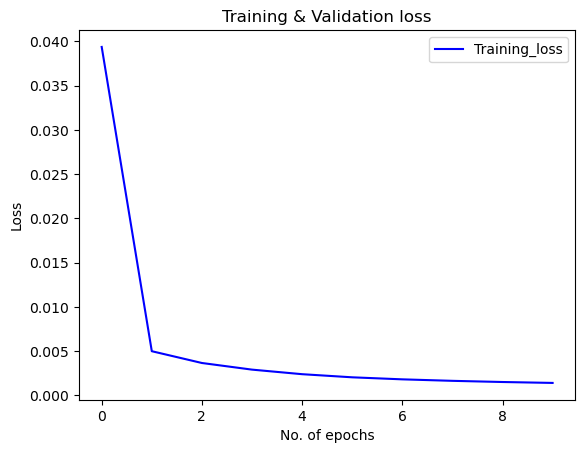

In [120]:
plt_loss_accuracy_fig_2(total_train_loss)

### 2.2. Try to recreate some images to observe.
Reload the pth first.

In [121]:
model_cnn_AE = conv_autoencoder().to(device)
pth_path = 'MNIST_model_CNN_AE.pth'
state_dict = torch.load(pth_path)
model_cnn_AE.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")

eval_loss = nn.MSELoss(reduction='none')

Load pth from MNIST_model_CNN_AE.pth


In [122]:
def show_10_comparisions(total_output):
    plt.figure(figsize=(2, 5))
    for i, img_idx in enumerate(range(0, 5)):
        img, output_img = total_output[img_idx]

        # image subplot
        ax_img = plt.subplot(5, 2, 2 * i + 1)
        ax_img.imshow(img.squeeze(), cmap='gray')
        ax_img.axis("off")
        ax_img.set_title(f"Original", fontsize=10)
        ax_img = plt.subplot(5, 2, 2 * i + 2)
        ax_img.imshow(output_img.squeeze(), cmap='gray')
        ax_img.axis("off")
        ax_img.set_title(f"Recreated", fontsize=10)
    plt.tight_layout()
    plt.show()

Loss: [0.0016303777229040861, 0.0008480047108605504, 0.0008315467275679111, 0.0012419077102094889, 0.0016722804866731167]


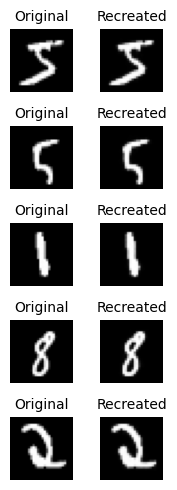

In [141]:
total_output = list()
total_test_loss = list()
for i in range(5):
    img, _ = mnist_train[i*100]
    img_batch = img.unsqueeze(0)
    output, loss = recreate_img(img_batch, model_cnn_AE, eval_loss)
    total_output.append((img, output.cpu().detach().numpy().squeeze(0)))
    total_test_loss.append(loss.cpu().item())
print("Loss:", total_test_loss)
show_10_comparisions(total_output)

#### 2.3 Set the threshold
By getting all the loss, and see the roc curve to find the best threshold.

100%|██████████| 157/157 [00:01<00:00, 155.66it/s]


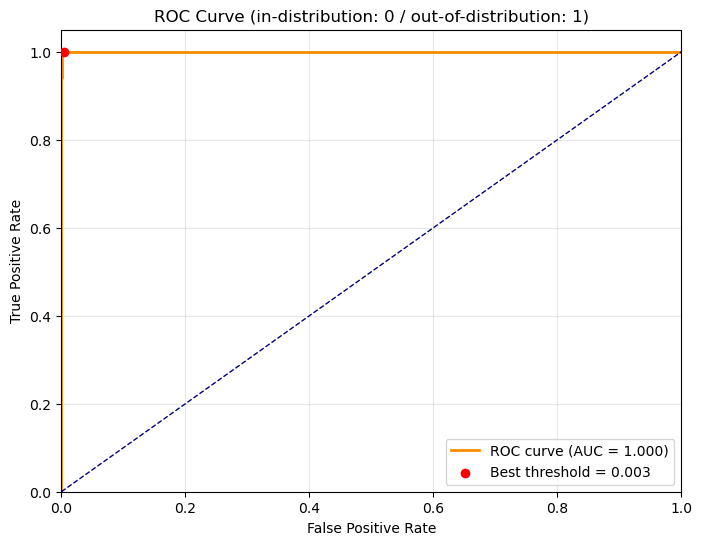

Best threshold on loss: 0.003231


In [139]:
from sklearn.metrics import roc_curve, auc

# Record total reconstruction losses for each image in the test sets
# Test on Fashion-MNIST (out-of-distribution data)
fashion_tot_loss_lst, mean_loss = test_2(fashion_test_loader, model_cnn_AE, eval_loss)

# Test on MNIST (in-distribution data)
mnist_tot_loss_lst, mean_loss = test_2(mnist_test_loader, model_cnn_AE, eval_loss)

# Create labels for ROC curve
# 1 for in-distribution (MNIST), 0 for out-of-distribution (Fashion-MNIST)
y_true = np.array([0]*len(mnist_tot_loss_lst) + [1]*len(fashion_tot_loss_lst))

# Combine all reconstruction losses into a single array
y_scores = np.array(mnist_tot_loss_lst + fashion_tot_loss_lst)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Use Youden's J statistic to find the best threshold
# Youden's J = TPR - FPR; maximum J indicates optimal threshold
youden_j = tpr - fpr
BEST_TH_2 = thresholds[np.argmax(youden_j)]

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Diagonal line for random guessing

# Mark the point corresponding to the best threshold
plt.scatter(fpr[np.argmax(youden_j)], tpr[np.argmax(youden_j)],
            color='red', label=f'Best threshold = {BEST_TH_2:.3f}', zorder=5)

# Set axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set axis labels and plot title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (in-distribution: 0 / out-of-distribution: 1)')

# Show legend and grid
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# Display the plot
plt.show()

# Print the best threshold value found on the (-loss) scale
print(f'Best threshold on loss: {BEST_TH_2:.6f}')


### 2.4 Show the result  of detecting anomalies in the test dataset.


In [140]:
mnsit_acc = 0.0
fashion_acc = 0.0
total_test_acc = 0.0
combined_tot_loss_lst, mean_loss = test_2(combined_test_loader, model_cnn_AE, eval_loss)
for i in combined_tot_loss_lst[:len(mnist_test)]:
    if i < BEST_TH_2:
        mnsit_acc += 1
        total_test_acc += 1
print(f"Achieved {mnsit_acc/len(mnist_test)*100:.4f}% accuracy in detecting in- and out-of-distribution samples on the mnist dataset.")
for i in combined_tot_loss_lst[len(mnist_test):]:
    if i >= BEST_TH_2:
        fashion_acc += 1
        total_test_acc += 1
print(f"Achieved {fashion_acc/len(fashion_test)*100:.4f}% accuracy in detecting in- and out-of-distribution samples on the fashion dataset.")

print(f"Achieved {total_test_acc/len(combined_test)*100:.4f}% accuracy in detecting in- and out-of-distribution samples on the combined test dataset (MNIST and Fashion-MNIST).")

100%|██████████| 313/313 [00:02<00:00, 146.95it/s]

Achieved 99.5100% accuracy in detecting in- and out-of-distribution samples on the mnist dataset.
Achieved 99.8400% accuracy in detecting in- and out-of-distribution samples on the fashion dataset.
Achieved 99.6750% accuracy in detecting in- and out-of-distribution samples on the combined test dataset (MNIST and Fashion-MNIST).


## 3. Train a **denoising autoencoder** using the normal data, and again use it to detect anomalies based on reconstruction error.
### 3.1. denoising autoencoder

In [188]:
class conv_denoise_autoencoder(nn.Module):
    def __init__(self):
        super(conv_denoise_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 1, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [192]:
# Hyper Parameters
LR = 0.001
NUM_EPOCHS = 20
IMAGE_SIZE = 28

model_cnn_deAE = conv_denoise_autoencoder().to(device)

# set loss function
criterion = nn.MSELoss()
# set optimizer
optimizer = torch.optim.Adam(model_cnn_deAE.parameters(), lr=LR, betas=(0.9, 0.999))
# Print the model summary
summary(model_cnn_deAE, (1, IMAGE_SIZE, IMAGE_SIZE)) # Input size: (Batch_size, height, width), torchinfo.summary need batch size

Layer (type:depth-idx)                   Output Shape              Param #
conv_denoise_autoencoder                 [1, 28, 28]               --
├─Sequential: 1-1                        [48, 7, 7]                --
│    └─Conv2d: 2-1                       [24, 14, 14]              408
│    └─ReLU: 2-2                         [24, 14, 14]              --
│    └─Conv2d: 2-3                       [48, 7, 7]                18,480
│    └─ReLU: 2-4                         [48, 7, 7]                --
├─Sequential: 1-2                        [1, 28, 28]               --
│    └─ConvTranspose2d: 2-5              [24, 14, 14]              18,456
│    └─ReLU: 2-6                         [24, 14, 14]              --
│    └─ConvTranspose2d: 2-7              [1, 28, 28]               385
│    └─Tanh: 2-8                         [1, 28, 28]               --
Total params: 37,729
Trainable params: 37,729
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 12.56
Input size (MB): 0.00
Forward/back

In [204]:
from tqdm import tqdm

NOSIE_STD = 0.8
# train and val func for one epoch
def train_epoch_3(train_dataloader, model, criterion, optimizer):
    model.train()
    tot_loss = list()
    for x, _ in tqdm(train_dataloader):
        x = x.to(device)

        # ADD Gaussian noise (mean=0, std=NOSIE_STD)
        noise = NOSIE_STD * torch.randn_like(x)
        x_noisy = x + noise
        x_noisy = torch.clamp(x_noisy, -1., 1.)
        # clear gradients
        optimizer.zero_grad()
        # predicting
        output = model(x_noisy)
        # see loss
        loss = criterion(output, x)
        loss.backward()
        
        # update the parameters
        optimizer.step()

        tot_loss.append(loss.item())
    return np.mean(tot_loss)

def test_3(test_dataloader, model, criterion):
    tot_loss = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(test_dataloader):
            _, _, losses = denoise_img(x, model, criterion)  # losses shape: (batch,)
            tot_loss.extend(losses.cpu().numpy().tolist())
    return tot_loss, np.mean(tot_loss)

def denoise_img(img_batch, model, criterion):
    model.eval()
    with torch.no_grad():
        img_batch = img_batch.to(device)

        noise = NOSIE_STD * torch.randn_like(img_batch)
        x_noisy = img_batch + noise
        x_noisy = torch.clamp(x_noisy, -1., 1.)

        output = model(x_noisy)
        loss_per_pixel = criterion(output, img_batch)  # shape: (batch, C, H, W)
        loss_per_image = loss_per_pixel.view(loss_per_pixel.size(0), -1).mean(dim=1)  # shape: (batch,)
    return x_noisy, output, loss_per_image  # return each image's loss

In [194]:
# Start training and testing
best_loss = 100
# For ploting the trend image
total_train_loss = []
for i in range(NUM_EPOCHS):
    train_loss = train_epoch_3(train_loader, model_cnn_deAE, criterion, optimizer)
    # record the training data
    total_train_loss.append(train_loss)

    print("Epoch[{:>2d}/{:>2d}] : train_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_loss))
    # update model pth when larger val_acc happens
    if(train_loss < best_loss):
        best_loss = train_loss
        save_parameters = True
        if save_parameters:
            path = 'MNIST_model_CNN_deAE.pth'
            torch.save(model_cnn_deAE.state_dict(), path)
            print("\t\33[33m====Save model parameters in {:s} when best_loss is {:.4f}====\33[0m".format(path, best_loss))

# save the final epoch's model
path = 'MNIST_model_CNN_deAE_final_epoch.pth'
torch.save(model_cnn_deAE.state_dict(), path)
print("\t\33[33m====Save FINAL model parameters in {:s}====\33[0m".format(path))

100%|██████████| 938/938 [00:07<00:00, 120.69it/s]


Epoch[ 1/20] : train_loss = 0.0701
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0701====


100%|██████████| 938/938 [00:07<00:00, 120.67it/s]


Epoch[ 2/20] : train_loss = 0.0339
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0339====


100%|██████████| 938/938 [00:08<00:00, 116.07it/s]


Epoch[ 3/20] : train_loss = 0.0322
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0322====


100%|██████████| 938/938 [00:09<00:00, 100.64it/s]


Epoch[ 4/20] : train_loss = 0.0314
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0314====


100%|██████████| 938/938 [00:09<00:00, 96.63it/s] 


Epoch[ 5/20] : train_loss = 0.0309
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0309====


100%|██████████| 938/938 [00:07<00:00, 123.22it/s]


Epoch[ 6/20] : train_loss = 0.0305
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0305====


100%|██████████| 938/938 [00:08<00:00, 116.10it/s]


Epoch[ 7/20] : train_loss = 0.0302
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0302====


100%|██████████| 938/938 [00:08<00:00, 114.94it/s]


Epoch[ 8/20] : train_loss = 0.0299
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0299====


100%|██████████| 938/938 [00:08<00:00, 114.99it/s]


Epoch[ 9/20] : train_loss = 0.0297
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0297====


100%|██████████| 938/938 [00:07<00:00, 118.24it/s]


Epoch[10/20] : train_loss = 0.0295
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0295====


100%|██████████| 938/938 [00:07<00:00, 120.90it/s]


Epoch[11/20] : train_loss = 0.0293
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0293====


100%|██████████| 938/938 [00:07<00:00, 120.33it/s]


Epoch[12/20] : train_loss = 0.0292
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0292====


100%|██████████| 938/938 [00:07<00:00, 119.14it/s]


Epoch[13/20] : train_loss = 0.0290
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0290====


100%|██████████| 938/938 [00:07<00:00, 119.54it/s]


Epoch[14/20] : train_loss = 0.0289
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0289====


100%|██████████| 938/938 [00:07<00:00, 119.97it/s]


Epoch[15/20] : train_loss = 0.0289
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0289====


100%|██████████| 938/938 [00:07<00:00, 120.08it/s]


Epoch[16/20] : train_loss = 0.0288
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0288====


100%|██████████| 938/938 [00:07<00:00, 120.75it/s]


Epoch[17/20] : train_loss = 0.0286
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0286====


100%|██████████| 938/938 [00:07<00:00, 121.02it/s]


Epoch[18/20] : train_loss = 0.0286
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0286====


100%|██████████| 938/938 [00:07<00:00, 121.18it/s]


Epoch[19/20] : train_loss = 0.0285
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0285====


100%|██████████| 938/938 [00:07<00:00, 121.12it/s]

Epoch[20/20] : train_loss = 0.0285
	====Save model parameters in MNIST_model_CNN_deAE.pth when best_loss is 0.0285====
	====Save FINAL model parameters in MNIST_model_CNN_deAE_final_epoch.pth====


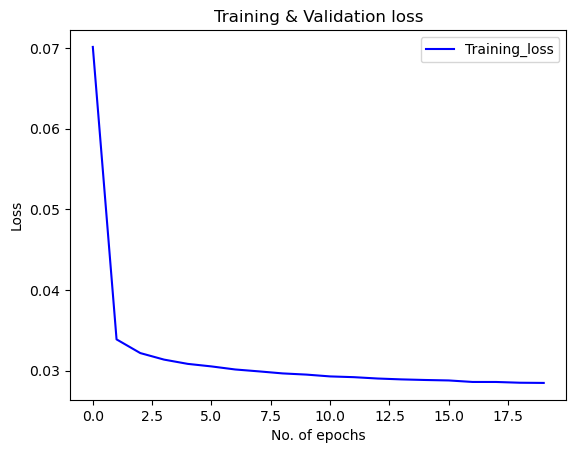

In [195]:
plt_loss_accuracy_fig_2(total_train_loss)

### 3.2 Try to denoise some images to observe.
Reload the pth first.

In [196]:
model_cnn_deAE = conv_denoise_autoencoder().to(device)
pth_path = 'MNIST_model_CNN_deAE.pth'
state_dict = torch.load(pth_path)
model_cnn_deAE.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")

eval_loss = nn.MSELoss(reduction='none')

Load pth from MNIST_model_CNN_deAE.pth


In [202]:
def show_10_comparisions_3(total_output):
    plt.figure(figsize=(2, 5))
    for i, img_idx in enumerate(range(0, 5)):
        img, output_img = total_output[img_idx]

        # image subplot
        ax_img = plt.subplot(5, 2, 2 * i + 1)
        ax_img.imshow(img.squeeze(), cmap='gray')
        ax_img.axis("off")
        ax_img.set_title(f"Added noise", fontsize=10)
        ax_img = plt.subplot(5, 2, 2 * i + 2)
        ax_img.imshow(output_img.squeeze(), cmap='gray')
        ax_img.axis("off")
        ax_img.set_title(f"Denoised", fontsize=10)
    plt.tight_layout()
    plt.show()

Loss: [0.033035241067409515, 0.027198148891329765, 0.06371639668941498, 0.03518420085310936, 0.03340212628245354]


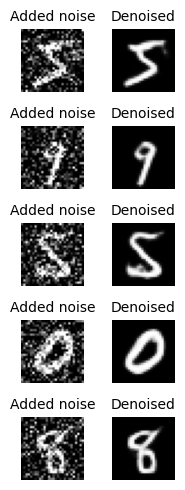

In [206]:
total_output = list()
total_test_loss = list()
for i in range(5):
    img, _ = mnist_train[i*133]
    img_batch = img.unsqueeze(0)
    noise_imgs, output, loss = denoise_img(img_batch, model_cnn_deAE, eval_loss)
    total_output.append((noise_imgs.cpu().detach().numpy().squeeze(0), output.cpu().detach().numpy().squeeze(0)))
    total_test_loss.append(loss.cpu().item())
print("Loss:", total_test_loss)
show_10_comparisions_3(total_output)

#### 3.3 Set the threshold
By getting all the loss, and see the roc curve to find the best threshold.

100%|██████████| 157/157 [00:01<00:00, 140.31it/s]


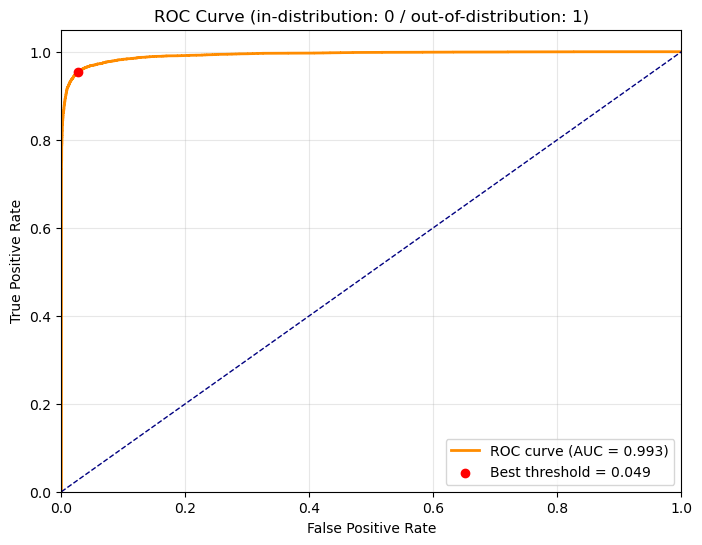

Best threshold on loss: 0.049286


In [207]:
from sklearn.metrics import roc_curve, auc

# Record total reconstruction losses for each image in the test sets
# Test on Fashion-MNIST (out-of-distribution data)
fashion_tot_loss_lst, mean_loss = test_3(fashion_test_loader, model_cnn_deAE, eval_loss)

# Test on MNIST (in-distribution data)
mnist_tot_loss_lst, mean_loss = test_3(mnist_test_loader, model_cnn_deAE, eval_loss)

# Create labels for ROC curve
# 1 for in-distribution (MNIST), 0 for out-of-distribution (Fashion-MNIST)
y_true = np.array([0]*len(mnist_tot_loss_lst) + [1]*len(fashion_tot_loss_lst))

# Combine all reconstruction losses into a single array
y_scores = np.array(mnist_tot_loss_lst + fashion_tot_loss_lst)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Use Youden's J statistic to find the best threshold
# Youden's J = TPR - FPR; maximum J indicates optimal threshold
youden_j = tpr - fpr
BEST_TH_3 = thresholds[np.argmax(youden_j)]

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Diagonal line for random guessing

# Mark the point corresponding to the best threshold
plt.scatter(fpr[np.argmax(youden_j)], tpr[np.argmax(youden_j)],
            color='red', label=f'Best threshold = {BEST_TH_3:.3f}', zorder=5)

# Set axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set axis labels and plot title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (in-distribution: 0 / out-of-distribution: 1)')

# Show legend and grid
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# Display the plot
plt.show()

# Print the best threshold value found on the (-loss) scale
print(f'Best threshold on loss: {BEST_TH_3:.6f}')


#### 3.4 Show the result  of detecting anomalies in the test dataset.


In [209]:
mnsit_acc = 0.0
fashion_acc = 0.0
total_test_acc = 0.0
combined_tot_loss_lst, mean_loss = test_3(combined_test_loader, model_cnn_deAE, eval_loss)
for i in combined_tot_loss_lst[:len(mnist_test)]:
    if i < BEST_TH_3:
        mnsit_acc += 1
        total_test_acc += 1
print(f"Achieved {mnsit_acc/len(mnist_test)*100:.4f}% accuracy in detecting in- and out-of-distribution samples on the mnist dataset.")
for i in combined_tot_loss_lst[len(mnist_test):]:
    if i >= BEST_TH_3:
        fashion_acc += 1
        total_test_acc += 1
print(f"Achieved {fashion_acc/len(fashion_test)*100:.4f}% accuracy in detecting in- and out-of-distribution samples on the fashion dataset.")

print(f"Achieved {total_test_acc/len(combined_test)*100:.4f}% accuracy in detecting in- and out-of-distribution samples on the combined test dataset (MNIST and Fashion-MNIST).")

100%|██████████| 313/313 [00:02<00:00, 137.04it/s]

Achieved 97.3500% accuracy in detecting in- and out-of-distribution samples on the mnist dataset.
Achieved 95.4900% accuracy in detecting in- and out-of-distribution samples on the fashion dataset.
Achieved 96.4200% accuracy in detecting in- and out-of-distribution samples on the combined test dataset (MNIST and Fashion-MNIST).


## 4. Apply the **Isolation Forest** algorithm directly on the data to identify Fashion-MNIST images as anomalies in the test dataset.

In [ ]:
from sklearn.ensemble import IsolationForest

In [329]:
i_forest = IsolationForest(
    n_estimators=400,               # number of tree
    # contamination='auto',           # ratio of anomaly data
    contamination=0.5,           # ratio of anomaly data
    max_samples='auto',
    max_features=1,
    bootstrap=False,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    warm_start=True
)

x_sample = np.array([combined_test[i][0].numpy().flatten() for i in range(len(combined_test))])
print(x_sample.shape)
# train the model
i_forest.fit(x_sample)
# predict to get the result
y_pred = i_forest.predict(x_sample) # 1: inliner；-1: outlier

(20000, 784)


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.3s remaining:    3.0s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished


### 4.1. See the predicted result.
Accuracy is 97%.

In [330]:
from sklearn.metrics import classification_report, confusion_matrix
# Ground truth : 0: inlier / 1: outlier
y_true = np.array([0]*len(mnist_test) + [1]*len(fashion_test))

print(confusion_matrix(y_true, (y_pred==-1).astype(int)))
print(classification_report(y_true, (y_pred==-1).astype(int)))

[[9707  293]
 [ 293 9707]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     10000
           1       0.97      0.97      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



## 5. Repeat step 4, but first **extract features** from the data using a pre-trained model (e.g., for MNIST digits) before applying the Isolation Forest.
### 5.1 I use **3. encoder in denoise autoencoder** to do feature extraction.

In [335]:
model_cnn_deAE = conv_denoise_autoencoder().to(device)
pth_path = 'MNIST_model_CNN_deAE.pth'
state_dict = torch.load(pth_path)
model_cnn_deAE.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")
feature_extractor = model_cnn_deAE.encoder
feature_extractor.eval()
summary(feature_extractor, (1, IMAGE_SIZE, IMAGE_SIZE))

Load pth from MNIST_model_CNN_deAE.pth


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [48, 7, 7]                --
├─Conv2d: 1-1                            [24, 14, 14]              408
├─ReLU: 1-2                              [24, 14, 14]              --
├─Conv2d: 1-3                            [48, 7, 7]                18,480
├─ReLU: 1-4                              [48, 7, 7]                --
Total params: 18,888
Trainable params: 18,888
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 6.35
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.14

Start to extract features.

In [336]:
features = []
with torch.no_grad():
    for x, _ in combined_test_loader:
        x = x.to(device)
        latent_feature = feature_extractor(x)
        features.append(latent_feature.cpu().numpy())
        
features = np.concatenate(features, axis=0) # features.shape : (20000, 24, 7, 7)
features = features.reshape(features.shape[0], -1) # features.shape : (20000, 1176)
print(features.shape)

(20000, 2352)


In [337]:
i_forest = IsolationForest(
    n_estimators=600,               # number of tree
    # contamination='auto',           # ratio of anomaly data
    contamination=0.5,           # ratio of anomaly data
    max_samples='auto',
    max_features=1,
    bootstrap=False,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    warm_start=True
)

# train the model
i_forest.fit(features)
# predict to get the result
y_pred = i_forest.predict(features) # 1: inliner；-1: outlier

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.6s remaining:    4.5s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.6s finished


### 5.2 See the predicted result after feature extraction.
Accuracy is 76%.

In [338]:
from sklearn.metrics import classification_report, confusion_matrix
# Ground truth : 0: inlier / 1: outlier
y_true = np.array([0]*len(mnist_test) + [1]*len(fashion_test))

print(confusion_matrix(y_true, (y_pred==-1).astype(int)))
print(classification_report(y_true, (y_pred==-1).astype(int)))

[[7576 2424]
 [2424 7576]]
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     10000
           1       0.76      0.76      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



### 6. Compare and analyze the anomaly detection performance of all five methods. Determine and justify an appropriate threshold for each method.
以下是紀錄對於**測試集(包含MNSIT & Fashion-MNIST test data)，找出anomalies**的**準確率**:
1. 使用RNN classifier(輸出10個類別):
    * **Detect anomalies ACC = 87.9650%**
    * 這個方法是判斷模型輸出的10個類別中的最大信心值(`max_prob`)是否有小於threshold，即為異常圖片。  
    而threshold的決定方法是藉由ROC curve去決定最好的threshold數值可以使準確率最高。  
    * threshold = 0.989304
2. 使用autoencoder(使輸入輸出圖片越相近越好):
    * **Detect anomalies ACC = 99.6750%**
    * 這個方法是判斷模型輸出與輸入的MSELoss有無大於threshold，即為異常圖片。而threshold的決定方法是藉由ROC curve去決定最好的threshold數值可以使準確率最高。 
    * threshold = 0.003231
3. 使用denoise autoencoder(使輸入圖片可以去除noise，進而回復成原始圖片):
    * **Detect anomalies ACC = 96.4200%**
    * 這個方法是判斷模型輸出與輸入的MSELoss有無大於threshold，即為異常圖片。而threshold的決定方法是藉由ROC curve去決定最好的threshold數值可以使準確率最高。 
    * threshold = 0.049286
4. 使用Isolation Forest直接對原始圖片資料做分離(MNIST當作0, Fashion-MNIST當作1):
    * **Detect anomalies ACC = 97%**
5. 先做feature extraction，再使用Isolation Forest直接對特徵資料做分離(MNIST當作0, Fashion-MNIST當作1):
    * **Detect anomalies ACC = 76%**
    * `feature_extractor`是使用**denoise autoencoder**中的`encoder`去進行特徵擷取。
### Result
方法2的效果最好(99.6750%)，可以抓出最多異常資料。